In [1]:
#-*- coding=utf-8 -*-
"""
spark_LR
Author: shi zheyang
Date:2020/5/27
Modified Date:2020/6/8 - 1.把LR放进pipeline 2.把离散化后的数值特征也做了one-hot 3.增加logging模块
"""
from pyspark.sql import SparkSession
from pyspark import SparkContext
from operator import itemgetter
import numpy as np
import logging
import sys

In [2]:
# 读取json文件
# SparkContext常用在RDD切入点，SparkSession是spark SQL的切入点
import time
start = time.time()
spark = SparkSession.builder.appName("MoviesLens_ItemCF").\
config('spark.driver.memory', '12g').getOrCreate() # config('spark.executor.memory','.12g').
ad_show_click = spark.read.json("../data/ctr_data/ad-behavior-20200318.json")
ad_show_click.select("user_id").show(truncate=False)
ad_show_click.printSchema()
ad_show_click.dtypes

+-------+
|user_id|
+-------+
|2938311|
|2532334|
|2401172|
|1650566|
|890817 |
|2671862|
|1334943|
|2934982|
|2835315|
|1828991|
|394443 |
|253831 |
|2871984|
|2530025|
|2827381|
|1505191|
|2853934|
|1314320|
|2208746|
|null   |
+-------+
only showing top 20 rows

root
 |-- ad_app_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ad_name: string (nullable = true)
 |-- ad_position: string (nullable = true)
 |-- ad_position_name: string (nullable = true)
 |-- ad_type: string (nullable = true)
 |-- app_version: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- event: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- network_type: string (nullable = true)
 |-- os: string (nullable = true)
 |-- proc_date: string (nullable = true)
 |-- proc_t

[('ad_app_id', 'string'),
 ('ad_id', 'string'),
 ('ad_name', 'string'),
 ('ad_position', 'string'),
 ('ad_position_name', 'string'),
 ('ad_type', 'string'),
 ('app_version', 'string'),
 ('carrier', 'string'),
 ('channel', 'string'),
 ('city', 'string'),
 ('country', 'string'),
 ('device_id', 'string'),
 ('device_model', 'string'),
 ('event', 'string'),
 ('ip', 'string'),
 ('network_type', 'string'),
 ('os', 'string'),
 ('proc_date', 'string'),
 ('proc_time', 'bigint'),
 ('province', 'string'),
 ('screen_height', 'bigint'),
 ('screen_width', 'bigint'),
 ('source', 'string'),
 ('sys_lang', 'string'),
 ('sys_version', 'string'),
 ('user_id', 'bigint')]

In [3]:
from pyspark.sql.functions import *
# 计算不同的个数
ad_show_click.agg(approx_count_distinct(ad_show_click.screen_height)).show()
ad_show_click.select(mean(ad_show_click.screen_height)).show()

+------------------------------------+
|approx_count_distinct(screen_height)|
+------------------------------------+
|                                 524|
+------------------------------------+

+------------------+
|avg(screen_height)|
+------------------+
|        1426.91661|
+------------------+



In [4]:
# 基本的统计
# 总共有多少条记录
ad_show_click = ad_show_click.distinct()
print("总条数, 总列数",ad_show_click.count(), len(ad_show_click.columns))
# 统计有多少个userID
print("userID个数",ad_show_click.select("user_id").distinct().count())
# 统计有多少个deviceID
print("deviceID个数",ad_show_click.select("device_id").distinct().count())
# 统计有多少个country
print("Country个数",ad_show_click.select("country").distinct().count())
# 统计有多少个ad_position
print("广告位个数",ad_show_click.select("ad_position").distinct().count())
# 统计有多少个source
print("来源",ad_show_click.select("source").distinct().count())

总条数, 总列数 99982 26
userID个数 47002
deviceID个数 50476
Country个数 99
广告位个数 34
来源 1


In [5]:
# 对数据先做一个join操作，得出标签
columns_to_drop = ['user_id', 'ad_position_name', 'city', 'proc_date', 'source', 'ad_name', 'os', "ip"]
ad_show_click = ad_show_click.drop(*columns_to_drop)
ad_show_click.printSchema()

root
 |-- ad_app_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ad_position: string (nullable = true)
 |-- ad_type: string (nullable = true)
 |-- app_version: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- country: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- event: string (nullable = true)
 |-- network_type: string (nullable = true)
 |-- proc_time: long (nullable = true)
 |-- province: string (nullable = true)
 |-- screen_height: long (nullable = true)
 |-- screen_width: long (nullable = true)
 |-- sys_lang: string (nullable = true)
 |-- sys_version: string (nullable = true)



In [6]:
ad_click = ad_show_click.where(col('event')=='adClick')
print(ad_click.count())
ad_click.printSchema()

6455
root
 |-- ad_app_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ad_position: string (nullable = true)
 |-- ad_type: string (nullable = true)
 |-- app_version: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- country: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- event: string (nullable = true)
 |-- network_type: string (nullable = true)
 |-- proc_time: long (nullable = true)
 |-- province: string (nullable = true)
 |-- screen_height: long (nullable = true)
 |-- screen_width: long (nullable = true)
 |-- sys_lang: string (nullable = true)
 |-- sys_version: string (nullable = true)



In [7]:
# 使用left_anti进行筛选展示的样本
ad_show = ad_show_click.join(ad_click, (ad_show_click.device_id==ad_click.device_id)&(ad_show_click.ad_id==ad_click.ad_id)&\
                             (ad_show_click.ad_position==ad_click.ad_position),"left_anti")
print(ad_show.count())

87074


In [8]:
ad_click = ad_click.withColumn('event', lit(1))
ad_show  = ad_show.withColumn('event', lit(0))
ad_click.show()
ad_show.show()

+---------+-----+-----------+-------+-----------+-------+-------+-------+--------------------+--------------------+-----+------------+-------------+--------------------+-------------+------------+--------+-----------+
|ad_app_id|ad_id|ad_position|ad_type|app_version|carrier|channel|country|           device_id|        device_model|event|network_type|    proc_time|            province|screen_height|screen_width|sys_lang|sys_version|
+---------+-----+-----------+-------+-----------+-------+-------+-------+--------------------+--------------------+-----+------------+-------------+--------------------+-------------+------------+--------+-----------+
|    10060|10113|  100600027|      3|   10000603|       |   ggps|     ES|8ca9fa3babea61ad6...|     Hisense T5 Plus|    1|      MOBILE|1584144081942|             Galicia|         1280|         720|      es|        7.0|
|    10060|10059|  100600001|      3|   10000707|       |   ggps|     ID|28a31a66a7ca68a29...|           vivo 1817|    1|      M

In [9]:
concat_data = ad_click.union(ad_show)
print(concat_data.count())

93529


In [10]:
# 特征分布
# 类别特征、数值类特征
from pyspark.sql.types import DoubleType
print(concat_data.describe())
concat_data = concat_data.withColumn("screen_height", concat_data["screen_height"].cast('int'))
concat_data = concat_data.withColumn("screen_width", concat_data["screen_width"].cast('int'))
concat_data.printSchema()

DataFrame[summary: string, ad_app_id: string, ad_id: string, ad_position: string, ad_type: string, app_version: string, carrier: string, channel: string, country: string, device_id: string, device_model: string, event: string, network_type: string, proc_time: string, province: string, screen_height: string, screen_width: string, sys_lang: string, sys_version: string]
root
 |-- ad_app_id: string (nullable = true)
 |-- ad_id: string (nullable = true)
 |-- ad_position: string (nullable = true)
 |-- ad_type: string (nullable = true)
 |-- app_version: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- country: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- event: integer (nullable = false)
 |-- network_type: string (nullable = true)
 |-- proc_time: long (nullable = true)
 |-- province: string (nullable = true)
 |-- screen_height: integer (nullable = true)
 |-- screen_

In [11]:
# Label 单独放
label = concat_data.select("event")
# 类别特征
category_feature_col = ["ad_app_id","ad_id", "ad_position", "ad_type", "app_version",  "country", "device_id", "device_model",\
                   "network_type", "sys_lang", "sys_version"]
category_feature = concat_data.select(*category_feature_col)
concat_data = concat_data.na.replace('','NA')
category_feature.show()
# 数值型特征
value_feature_col = ["screen_height", "screen_width"] # , "proc_time"
value_feature = concat_data.select(*value_feature_col)
value_feature.show()

+---------+-----+-----------+-------+-----------+-------+--------------------+--------------------+------------+--------+-----------+
|ad_app_id|ad_id|ad_position|ad_type|app_version|country|           device_id|        device_model|network_type|sys_lang|sys_version|
+---------+-----+-----------+-------+-----------+-------+--------------------+--------------------+------------+--------+-----------+
|    10060|10113|  100600027|      3|   10000603|     ES|8ca9fa3babea61ad6...|     Hisense T5 Plus|      MOBILE|      es|        7.0|
|    10060|10059|  100600001|      3|   10000707|     ID|28a31a66a7ca68a29...|           vivo 1817|      MOBILE|      in|      8.1.0|
|    10060|10064|  100600002|      2|   10000603|     AR|a0a91a69af8a86a19...|         lge LG-H320|      MOBILE|      es|      5.0.1|
|    10060|10064|  100600002|      2|   10000707|     US|a0acca2ba1dab3af0...|    samsung SM-G955U|        WIFI|      en|          9|
|    10060|10056|  100600004|      3|   10000707|     BO|3caf7

In [12]:
train, test = concat_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 65252
Test Dataset Count: 28277


In [13]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, MinMaxScaler, VectorAssembler, QuantileDiscretizer
from pyspark.ml.classification import LogisticRegression
# 进行特征转换
stages = []
# 类别特征进行stringindexer和onehot变换
for column in category_feature_col:
        stringindexer = StringIndexer(inputCol=column, outputCol=column+'index').setHandleInvalid('keep')
        encoder = OneHotEncoderEstimator(inputCols=[stringindexer.getOutputCol()], outputCols=[column + 'classVec'])
        stages += [stringindexer,encoder]
# 离散化（这里可以也再来一次one-hot）
for column in value_feature_col:
    discretizer = QuantileDiscretizer(numBuckets=2, inputCol=column, outputCol=column+"result")
    v_encoder = OneHotEncoderEstimator(inputCols=[discretizer.getOutputCol()], outputCols=[column + 'classVal'])
    stages += [discretizer,v_encoder]

# 把多个特征转成vector
assemblerInputs = [c + "classVec" for c in category_feature_col] + [column+"classVal" for c in value_feature_col]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
lr = LogisticRegression(featuresCol='features', labelCol='event', maxIter=30)
stages += [lr]
pipeline = Pipeline(stages=stages)
%time model = pipeline.fit(train)
# output = model.transform(train)
# output.show()

CPU times: user 118 ms, sys: 28.6 ms, total: 146 ms
Wall time: 3min 46s


In [14]:
# 保存模型和加载模型
model.write().overwrite().save("../model/pipeline_model")
loaded_model = PipelineModel.load("../model/pipeline_model")

In [15]:
# 获取logger实例，如果参数为空，则返回root logger
logger = logging.getLogger("spark_LR")
# 指定logger输出格式
formatter = logging.Formatter('%(asctime)s %(levelname)-8s: %(message)s')
# 文件日志
file_handler = logging.FileHandler("../log/spark_lr_log.txt")
file_handler.setFormatter(formatter)
# 控制台日志
console_handler = logging.StreamHandler(sys.stdout)
console_handler.formatter = formatter 
# 为logger添加的日志处理器，可以自定义日志处理器让其输出到其他地方
logger.addHandler(file_handler)
logger.addHandler(console_handler)
# 指定日志的最低级别，默认为WARN级别
logger.setLevel(logging.INFO)

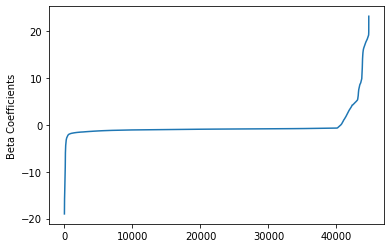

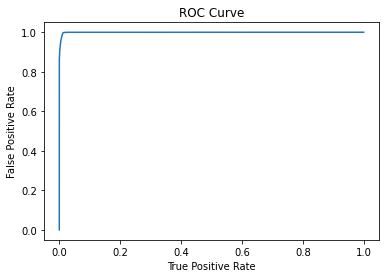

Training set areaUnderROC: 0.9993909601113756


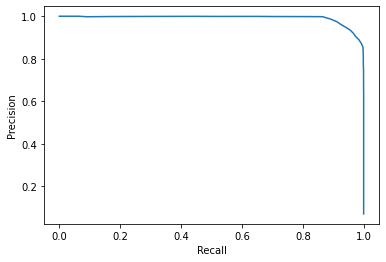

In [16]:
import matplotlib.pyplot as plt 
import numpy as np

beta = np.sort(model.stages[-1].coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
# 绘制图线
trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR']) # 准确率，召回率
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [17]:
from pyspark.sql import SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
# udf可以自定义函数操作每一个值，类似以前的map
func = udf(lambda x: float(x[1]), FloatType())
predictions = loaded_model.transform(test)
# predictions.show()
predictions = predictions.select("device_id", "ad_id", "ad_position", col("event").alias("label"), "features", "rawPrediction", "probability", "prediction")
predictions.show(10)
predictions_json = predictions.withColumn("pvalue", func("probability"))
predictions_json = predictions_json.drop("label", "features", "rawPrediction", "probability", "prediction")
predictions_json.show()

+--------------------+-----+-----------+-----+--------------------+--------------------+--------------------+----------+
|           device_id|ad_id|ad_position|label|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+-----------+-----+--------------------+--------------------+--------------------+----------+
|fca42a03aeaab2a85...|10056|  100600004|    1|(44748,[0,7,40,70...|[-6.3679048779424...|[0.00171281141207...|       1.0|
|3caf7aa4a2daf8a49...|10056|  100600004|    1|(44748,[0,7,40,70...|[-2.5669849164057...|[0.07129367759153...|       1.0|
|98a39a8eac5a4aa31...|10057|  100600005|    1|(44748,[0,12,45,7...|[-0.6418852491265...|[0.34482050067505...|       1.0|
|14a30ac6a59a42a70...|10063|  100600003|    1|(44748,[0,3,36,69...|[9.22454036263687...|[0.99990141968366...|       0.0|
|98ab8abaa35ae8a04...|10064|  100600002|    1|(44748,[0,2,35,69...|[9.68014824791223...|[0.99993749167175...|       0.0|
|7caf3a1ba9fafead6...|10064|  10

In [18]:
# 进行模型评估
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator() # 评估
print('Test Area Under ROC', evaluator.evaluate(predictions))
print("耗时：", time.time() - start, "s")

Test Area Under ROC 0.891296396186407
耗时： 276.72425055503845 s


In [19]:
predictions_json.write.json('result.json', mode='overwrite')
# predictions_json.rdd.saveAsTextFile('result_rdd.json')